In [65]:
import math
import numpy as np
import scipy.signal
import pandas as pd
import csv
import matplotlib.pyplot as plt

In [66]:
def compute_air_absorption_coefficients(T, p, rel_hum, freqs):
        """
        Computes air absorption coefficients at a set of nbands equispaced frequencies in the range `[0, fs]`, based
        on the ISO 9613-1 standard. 

        A different formulation can be found in 
        `Keith Attenborough, "Sound Propagation in the Atmosphere", Springer Handbook of Acoustics`, and can be set
        by using T01 = 293.15
        The coefficients depend on the atmsopsheric temperature, pressure and relative humidity.

        Parameters
        ----------
        nbands: int
            Number of frequency bands in which to compute air absorption coefficients, by default 50

        Returns
        -------
        np.ndarray
            1D Array containing nbands air absorption coefficients, computed in dB scale, at the defined 
            set of frequencies

        """

        T0 = 293.15     # Standard room temperature T = 20deg Celsius
        T01 = 273.16    # Triple point isotherm temperature, ISO 9613-1
        T = T + 273.15
        ps0 = 1         # Standard atmospheric pressure in atm

        f = freqs # np.linspace(0, fs, num=nbands)     # Frequencies in which coeffs will be computed
        
        Csat = -6.8346 * math.pow(T01 / T, 1.261) + 4.6151
        rhosat = math.pow(10, Csat)
        H = rhosat * rel_hum * ps0 / p

        frn = (p / ps0) * math.pow(T0 / T, 0.5) * (
                9 + 280 * H * math.exp(-4.17 * (math.pow(T0 / T, 1/3.) - 1)))

        fro = (p / ps0) * (24.0 + 4.04e4 * H * (0.02 + H) / (0.391 + H))

        alpha = f * f * (
            1.84e-11 / ( math.pow(T0 / T, 0.5) * p / ps0 )
            + math.pow(T / T0, -2.5)
            * (
                0.10680 * math.exp(-3352 / T) * frn / (f * f + frn * frn)
                + 0.01278 * math.exp(-2239.1 / T) * fro / (f * f + fro * fro)
                )
            )
        
        return alpha * 20 / np.log(10)

def compute_air_absorption_filter(alpha, freqs, distance, numtaps):
        """
        Computes air absorption filter as a FIR filter with `numtaps` coefficients. The filter depends
        on the distance travelled by the sound wave between the source and the receiver.

        Parameters
        ----------
        distance : float
            Distance travelled by the sound wave, in meters
        numtaps : int
            Number of coefficients of the FIR filter

        Returns
        -------
        np.ndarray
            1D array containing `numtaps` FIR filter coefficients modelling air absorption
        """

        alpha_lin = 10 ** (-alpha * distance / 20)     # Convert coeffs in dB to linear scale
        freqs_norm = freqs / max(freqs)
        filt_coeffs = scipy.signal.firls(numtaps, freqs_norm, alpha_lin)
        
        return filt_coeffs

In [84]:
# Parameters
T = -10
p = 1
rel_hum = 80
fs = 8000
numbands = 50
freqs = np.linspace(0, fs / 2, numbands)
alpha = compute_air_absorption_coefficients(T, p, rel_hum, freqs)

# Distance
d = 2

# Filter
import time
start_time = time.time()
coeffs = compute_air_absorption_filter(alpha, freqs, d, 11)
print(np.shape(coeffs))
print(time.time() - start_time)

(11,)
0.000743865966796875


In [85]:
d = np.arange(0,300,1)
coeffs = np.zeros((len(d), 11))

np.reshape(compute_air_absorption_filter(alpha, freqs, d[0], 11), (1, 11))
for i in range(len(d)):
    coeffs[i] = compute_air_absorption_filter(alpha, freqs, d[i], 11)

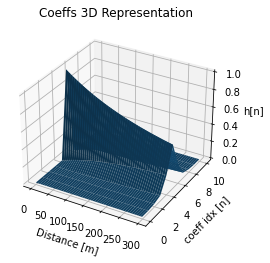

In [86]:

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
plt.title('Coeffs 3D Representation')
ax.set_xlabel('Distance [m]')
ax.set_ylabel('coeff idx [n]')
ax.set_zlabel('h[n]')
ax.plot_surface(d[:, None], range(11), coeffs)
plt.show()


In [87]:
# Select coefficients to interpolate
coef_idx = 5
idxs = [0, 25, 50, 75, 99]
coefs_list = coeffs[idxs, coef_idx]

# Perform interpolation
model = np.polyfit(d[idxs], coefs_list, 4)

new_data_points = np.array([13]) # np.arange(0,300,1)
new_data_points = np.arange(0,300,1)
new_coeffs = np.polyval(model, new_data_points)

Text(0.5, 0, 'Distance [m]')

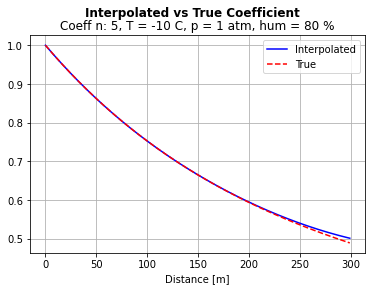

In [100]:
plt.figure()
plt.plot(new_data_points, new_coeffs, 'b')
plt.plot(coeffs[:,coef_idx], 'r--')
plt.grid()
plt.legend(['Interpolated', 'True'])
plt.suptitle('Interpolated vs True Coefficient', fontweight = 'bold')
plt.title(f'Coeff n: {coef_idx}, T = {T} C, p = {p} atm, hum = {rel_hum} %')
plt.xlabel('Distance [m]')

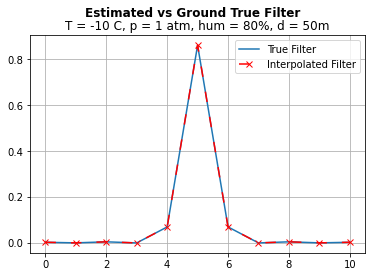

In [135]:
new_coeffs = np.zeros(11)
for i in range(11):
    idxs = [0, 25, 50, 75, 99]
    coefs_list = coeffs[idxs, i]

    # Perform interpolation
    model = np.polyfit(d[idxs], coefs_list, 4)

    new_data_points = np.array([d[50]]) # np.arange(0,300,1)
    # new_data_points = np.arange(0,300,1)
    new_coeffs[i] = np.polyval(model, new_data_points)

plt.plot(coeffs[50])
plt.plot(new_coeffs, 'rx', linestyle = 'dashed', dashes = (7,10))
plt.grid()
plt.suptitle('Estimated vs Ground True Filter', fontweight = 'bold')
plt.title(f'T = {T} C, p = {p} atm, hum = {rel_hum}%, d = 50m')
plt.legend(['True Filter', 'Interpolated Filter'])


In [4]:
import numpy as np
np.array([1,1,1]) * 2 + np.array([1,1,1]) * 2 ** 2 + np.array([1,1,1]) * 2 ** 3

array([14, 14, 14])

In [102]:
coeffs[1]

array([ 2.96409330e-05, -4.34032768e-05,  8.01709117e-05, -1.08745215e-04,
        1.58781335e-03,  9.96911067e-01,  1.58781335e-03, -1.08745215e-04,
        8.01709117e-05, -4.34032768e-05,  2.96409330e-05])